In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import required sklearn modules
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# import the metrics class
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Perform cross validation
from sklearn.model_selection import cross_val_score  

# Import the preprocessing class
from sklearn.preprocessing import OneHotEncoder

# Impute values
from sklearn.impute import SimpleImputer 
# Create pipelines
from sklearn.pipeline import Pipeline
# Transform columns
from sklearn.compose import ColumnTransformer
# Configures sklearn to display pipeline diagrams
from sklearn import set_config
set_config(display="diagram")

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import LabelEncoder
import numpy as np
#nltk
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

In [2]:
def lemmatize_pos_tagged_text(text, lemmatizer, pos_tag_dict):
  sentences = nltk.sent_tokenize(text)
  new_sentences = []

  for sentence in sentences:
    sentence = sentence.lower()
    new_sentence_words = []
    #one pos_tuple for sentence
    pos_tuples = nltk.pos_tag(nltk.word_tokenize(sentence)) 

    for word_idx, word in enumerate(nltk.word_tokenize(sentence)):
      nltk_word_pos = pos_tuples[word_idx][1]
      wordnet_word_pos = pos_tag_dict.get(
                          nltk_word_pos[0].upper(), None)
      if wordnet_word_pos is not None:
        new_word = lemmatizer.lemmatize(word, wordnet_word_pos)
      else:
        new_word = lemmatizer.lemmatize(word)

      new_sentence_words.append(new_word)

    new_sentence = " ".join(new_sentence_words)
    new_sentences.append(new_sentence)

  return " ".join(new_sentences)

In [3]:
def download_if_non_existent(res_path, res_name):
    try:
        nltk.data.find(res_path)
    except LookupError:
        print(f'resource {res_path} not found. Downloading now...')
        nltk.download(res_name)

class NltkPreprocessingSteps:
    def __init__(self, X):
        self.X = X
        download_if_non_existent('corpora/stopwords', 'stopwords')
        download_if_non_existent('tokenizers/punkt', 'punkt')
        download_if_non_existent('taggers/averaged_perceptron_tagger',
                                 'averaged_perceptron_tagger')
        download_if_non_existent('corpora/wordnet', 'wordnet')
        download_if_non_existent('corpora/omw-1.4', 'omw-1.4')

        self.sw_nltk = stopwords.words('english')
        new_stopwords = ['<*>']
        self.sw_nltk.extend(new_stopwords)
        self.sw_nltk.remove('not')

        self.pos_tag_dict = {"J": wordnet.ADJ,
                             "N": wordnet.NOUN,
                             "V": wordnet.VERB,
                             "R": wordnet.ADV}

        # '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~' 32 punctuations in python
        # we dont want to replace . first time around
        self.remove_punctuations = string.punctuation.replace('.', '')

    def to_lower(self):
        self.X = np.apply_along_axis(lambda x: x.lower(), self.X)
        return self

    def expand_contractions(self):
        self.X = self.X.apply(
            lambda x: " ".join([contractions.fix(expanded_word)
                                for expanded_word in str(x).split()]))
        return self

    def remove_numbers(self):
        self.X = self.X.apply(lambda x: re.sub(r'\d+', '', x))
        return self

    def replace_dots_with_spaces(self):
        self.X = self.X.apply(lambda x: re.sub("[.]", " ", x))
        return self

    def remove_punctuations_except_periods(self):
        self.X = self.X.apply(
            lambda x: re.sub('[%s]' %
                             re.escape(self.remove_punctuations), '', x))
        return self

    def remove_all_punctuations(self):
        self.X = self.X.apply(lambda x: re.sub('[%s]' %
                                               re.escape(string.punctuation), '', x))
        return self

    def remove_double_spaces(self):
        self.X = self.X.apply(lambda x: re.sub(' +', ' ', x))
        return self

    def remove_double_spaces(self):
        self.X = self.X.apply(lambda x: re.sub(' +', ' ', x))
        return self

    def fix_typos(self):
        self.X = self.X.apply(lambda x: str(TextBlob(x).correct()))
        return self

    def remove_stopwords(self):
        # remove stop words from token list in each column
        self.X = self.X.apply(
            lambda x: " ".join([word for word in x.split()
                                if word not in self.sw_nltk]))
        return self

    def lemmatize(self):
        lemmatizer = WordNetLemmatizer()
        self.X = self.X.apply(lambda x: lemmatize_pos_tagged_text(
            x, lemmatizer, self.pos_tag_dict))
        return self

    def get_processed_text(self):
        return self.X

In [4]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
import contractions

In [5]:
class NltkTextPreprocessor(TransformerMixin, BaseEstimator):
  def __init__(self):
    pass

  def fit(self, X, y):
    return self

  def transform_series(self, X):
      txt_preproc = NltkPreprocessingSteps(X.copy())
      processed_text = \
              txt_preproc \
              .expand_contractions()\
              .remove_numbers()\
              .remove_punctuations_except_periods()\
              .lemmatize()\
              .remove_double_spaces()\
              .remove_all_punctuations()\
              .remove_stopwords()\
              .get_processed_text()
      return processed_text

  def transform(self, X):
    if isinstance(X, pd.DataFrame):
        X = X.copy()
        for c in X:
          X[c] = self.transform_series(X[c])
        return X
    else:
        return self.transform_series(X)

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler


n_tokens = 10000

nlp_transformer = Pipeline(
    steps=[
        ("nltk_preproc", NltkTextPreprocessor()),
        ("vect", CountVectorizer(max_features=n_tokens)),
        ("tfidf", TfidfTransformer()),
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("nlp", nlp_transformer, 'PRODUCT DESCRIPTION')
    ]
)

## Prepare data.

In [7]:
dtypes = {'PRODUCT DESCRIPTION' : 'str', 'PRODUCT DESCRIPTION_ASCII' : 'str'}
label_col = 'HS CODE6'

train_dataset = pd.read_csv('input/hc_codes_train_IND.csv.gz', dtype=dtypes)[['PRODUCT DESCRIPTION', label_col]]


In [8]:
len(train_dataset)

844941

In [9]:
# Load dataset
dtypes = {'PRODUCT DESCRIPTION' : 'str', 'PRODUCT DESCRIPTION_ASCII' : 'str'}
label_col = 'HS CODE6'
labels = set([])

#Load to pandas
train_dataset = pd.read_csv('input/hc_codes_train_IND.csv.gz', dtype=dtypes)[['PRODUCT DESCRIPTION', label_col]]
#Sample max 50 labels per class
#train_dataset = train_dataset.groupby('HS CODE6').apply(
#            lambda x: x.sample(min(50, len(x)))
#        )
train_dataset['label'] = train_dataset[label_col].astype(int)
train_dataset = train_dataset[train_dataset['PRODUCT DESCRIPTION'].str.len() > 2]
labels.update(train_dataset['label'].unique())

test_dataset = pd.read_csv('input/hc_codes_test_IND.csv.gz', dtype=dtypes)[['PRODUCT DESCRIPTION', label_col]]
test_dataset['label'] = test_dataset[label_col].astype(int)
labels.update(test_dataset['label'].unique())

val_dataset = pd.read_csv('input/hc_codes_valid_IND.csv.gz', dtype=dtypes)[['PRODUCT DESCRIPTION', label_col]]
val_dataset['label'] = val_dataset[label_col].astype(int)
labels.update(val_dataset['label'].unique())

# We will need this to directly output the class names when using the pipeline without mapping the labels later.
# Extract the number of classes and their names
class_names = labels
num_labels = len(class_names)
print(f"number of labels: {num_labels}")
#print(f"the labels: {class_names}")

# Create an id2label mapping
id2label = {i: int(label) for i, label in enumerate(class_names)}
label2id = {label : idx for idx, label in id2label.items()}
print ('Map labels to ids')
train_dataset = train_dataset.replace({"label": label2id})
test_dataset = test_dataset.replace({"label": label2id})
val_dataset = val_dataset.replace({"label": label2id})

number of labels: 5612
Map labels to ids


### Word cloud

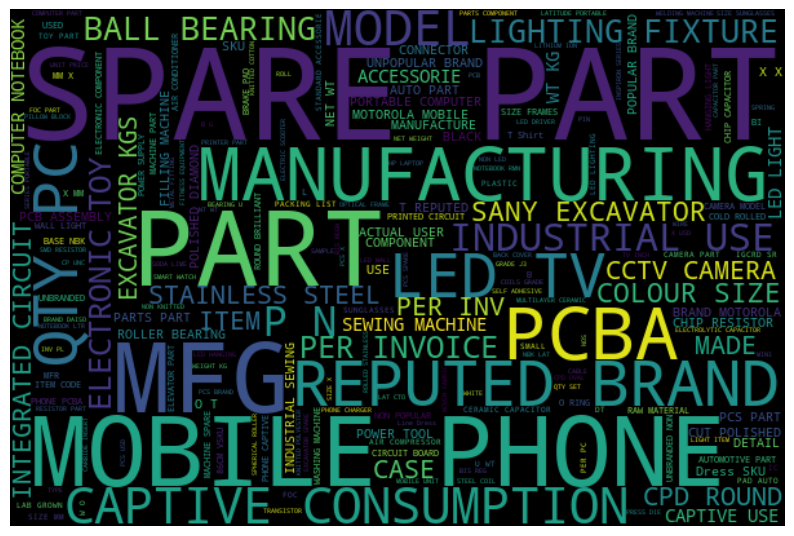

In [10]:
all_words_lem = ' '.join([word for word in train_dataset['PRODUCT DESCRIPTION']])
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

## Markdown

In [11]:
X_train, y_train = preprocessor.fit_transform(train_dataset, train_dataset['label']), train_dataset['label']
X_test, y_test = preprocessor.transform(test_dataset), test_dataset['label']
X_val, y_val = preprocessor.transform(val_dataset), val_dataset['label']

resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Error loading wordnet: <urlopen error [Errno 101] Network
[nltk_data]     is unreachable>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 101] Network
[nltk_data]     is unreachable>


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Error loading wordnet: <urlopen error [Errno 101] Network
[nltk_data]     is unreachable>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 101] Network
[nltk_data]     is unreachable>


resource corpora/wordnet not found. Downloading now...
resource corpora/omw-1.4 not found. Downloading now...


[nltk_data] Error loading wordnet: <urlopen error [Errno 101] Network
[nltk_data]     is unreachable>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 101] Network
[nltk_data]     is unreachable>


In [12]:
X_train

<844939x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 4614168 stored elements in Compressed Sparse Row format>

In [13]:
import scipy.sparse
save_data = True
if save_data:
    scipy.sparse.save_npz(f'X_train{n_tokens}.npz', X_train)
    scipy.sparse.save_npz(f'X_test{n_tokens}.npz', X_test)
    scipy.sparse.save_npz(f'X_val{n_tokens}.npz', X_val)

    y_train.to_csv(f'y_train{n_tokens}.csv.gz',index=False)
    y_test.to_csv(f'y_test{n_tokens}.csv.gz',index=False)
    y_val.to_csv(f'y_val{n_tokens}.csv.gz',index=False)

In [14]:
import scipy.sparse
save_data = True
if save_data:
    scipy.sparse.save_npz(f'X_train{n_tokens}_sampled.npz', X_train)
    scipy.sparse.save_npz(f'X_test{n_tokens}_sampled.npz', X_test)
    scipy.sparse.save_npz(f'X_val{n_tokens}_sampled.npz', X_val)

    y_train.to_csv(f'y_train{n_tokens}_sampled.csv.gz',index=False)
    y_test.to_csv(f'y_test{n_tokens}_sampled.csv.gz',index=False)
    y_val.to_csv(f'y_val{n_tokens}_sampled.csv.gz',index=False)

## SVM

In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score

if True:
    svc = LinearSVC(random_state=0)

    svc.fit(X_train,y_train)

    y_hat = svc.predict(X_test)

    f1s = f1_score(y_hat, y_test, average="weighted")
    accuracy = accuracy_score(y_hat, y_test)

    print(f"F1 score: {f1s:.3f}")
    print(f"Accuracy: {accuracy:.3f}")

/state/partition1/llgrid/pkg/anaconda/python-LLM-2023b/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


F1 score: 0.749
Accuracy: 0.743
